# Analyze 2021 Citibike Data Anomalies
Gender and "user type" distributions in February+March 2021 Citibike data are way out of line with historical averages; [skip to plots at the end](#gender).

In [1]:
from boto3 import client
from datetime import datetime as dt
import pandas as pd
from tempfile import TemporaryDirectory
from zipfile import ZipFile

Public Citibike data is published to the `tripdata` Amazon S3 bucket:

In [2]:
s3 = client('s3')
bucket = 'tripdata'

We'll look at 2020 and 2021 data:

In [3]:
start = (2020, 1)
end = (2021, 3)

In [4]:
months = pd.date_range(*[ pd.to_datetime('%d-%02d' % (y, m)) for y,m in [start, end]], freq='MS').to_series()

Download one {month,region}'s data, tag it with {year,month,region}:

In [5]:
def load_csv(date, jc=False):
    y, m = date.year, date.month
    if jc:
        base = 'JC-'
    else:
        base = ''
    base += '%d%02d-citibike-tripdata' % (y, m)
    zip_key = f'{base}.csv.zip'
    with TemporaryDirectory() as d:
            zip_path = f'{d}/{base}.zip'
            s3.download_file(bucket, zip_key, zip_path)
            z = ZipFile(zip_path)
            names = z.namelist()
            print(f'{zip_key} contains names: {names}')
            [ name ] = [ f for f in names if f.endswith('.csv') and not f.startswith('_') ]
            with z.open(name,'r') as i:
                df = pd.read_csv(i)
                df = df[['gender','usertype']]
                df['year'] = y
                df['month'] = m
                if jc:
                    df['region'] = 'JC'
                else:
                    df['region'] = 'NYC'
                return df

Download + Concatenate all applicable months' data:

In [6]:
df = pd.concat([
    load_csv(month, jc=jc)
    for month in months.tolist()
    for jc in [False,True]
])
df

202001-citibike-tripdata.csv.zip contains names: ['202001-citibike-tripdata.csv']
JC-202001-citibike-tripdata.csv.zip contains names: ['JC-202001-citibike-tripdata.csv']
202002-citibike-tripdata.csv.zip contains names: ['202002-citibike-tripdata.csv']
JC-202002-citibike-tripdata.csv.zip contains names: ['JC-202002-citibike-tripdata.csv']
202003-citibike-tripdata.csv.zip contains names: ['202003-citibike-tripdata.csv']
JC-202003-citibike-tripdata.csv.zip contains names: ['JC-202003-citibike-tripdata.csv']
202004-citibike-tripdata.csv.zip contains names: ['202004-citibike-tripdata.csv']
JC-202004-citibike-tripdata.csv.zip contains names: ['JC-202004-citibike-tripdata.csv']
202005-citibike-tripdata.csv.zip contains names: ['202005-citibike-tripdata.csv']
JC-202005-citibike-tripdata.csv.zip contains names: ['JC-202005-citibike-tripdata.csv']
202006-citibike-tripdata.csv.zip contains names: ['202006-citibike-tripdata.csv', '__MACOSX/', '__MACOSX/._202006-citibike-tripdata.csv']
JC-202006-ci

,gender,usertype,year,month,region
0,1,Subscriber,2020,1,NYC
1,1,Customer,2020,1,NYC
2,1,Subscriber,2020,1,NYC
3,1,Subscriber,2020,1,NYC
4,1,Subscriber,2020,1,NYC
...,...,...,...,...,...
16838,0,Customer,2021,3,JC
16839,0,Customer,2021,3,JC
16840,0,Customer,2021,3,JC
16841,0,Customer,2021,3,JC


Map 0, 1, 2 "gender" values to "U" (unspecified), "M" (male), and "F" (female):

In [7]:
df['gender'] = df['gender'].apply(lambda g: 'UMF'[int(g)])

Build count and percentage tables:

In [8]:
def column_hist(df, k, region=False):
    idx_keys = ['year','month']
    if region:
        idx_keys += ['region']
    all_keys = idx_keys + [k]
    counts = df[all_keys].value_counts().rename('count')
    counts = counts.reset_index().sort_values(all_keys).set_index(idx_keys)
    hist = counts.pivot_table(values='count', index=counts.index, columns=k, aggfunc='sum')
    hist = hist.set_index(pd.MultiIndex.from_tuples(hist.index))
    total = hist.sum(axis=1)
    for c in hist.columns:
        hist[f'{c}%'] = round(hist[c] / total * 100, 1)
    counts['date'] = counts.index.to_frame().apply(lambda r: pd.to_datetime('%d-%02d' % (r['year'], r['month'])), axis=1)
    return counts, hist

## Counts, Percentages <a id="counts"></a>

In [9]:
gc, gh = column_hist(df, 'gender')
uc, uh = column_hist(df, 'usertype')
hist = pd.concat([gh, uh], axis=1)
hist

F        M        U    F%    M%    U%  Customer  Subscriber  \
2020 1   285447   923058    58111  22.5  72.9   4.6     96361     1170255   
     2   262576   849540    57676  22.4  72.6   4.9     93412     1076380   
     3   268061   735000    83115  24.7  67.7   7.7    156916      929260   
     4   194014   418333    79683  28.0  60.5  11.5    168843      523187   
     5   467337   829858   215772  30.9  54.8  14.3    487956     1025011   
     6   596187  1063802   259205  31.1  55.4  13.5    592681     1326513   
     7   643250  1220810   280428  30.0  56.9  13.1    590242     1554246   
     8   701683  1354642   316456  29.6  57.1  13.3    674539     1698242   
     9   760316  1467116   314626  29.9  57.7  12.4    689100     1852958   
     10  662396  1353441   263118  29.1  59.4  11.5    555646     1723309   
     11  502220  1071074   184685  28.6  60.9  10.5    380064     1377915   
     12  293184   711540    95899  26.6  64.6   8.7    170602      930021   
2021 1   292460   722418    92092  26.4  65.3   8.3    152153      954817   
     2    46415   125890   467051   7.3  19.7  73.1    472083      167273   
     3    59984   129357  1321559   4.0   8.6  87.5   1331580      179320   

         Customer%  Subscriber%  
2020 1         7.6         92.4  
     2         8.0         92.0  
     3        14.4         85.6  
     4        24.4         75.6  
     5        32.3         67.7  
     6        30.9         69.1  
     7        27.5         72.5  
     8        28.4         71.6  
     9        27.1         72.9  
     10       24.4         75.6  
     11       21.6         78.4  
     12       15.5         84.5  
2021 1        13.7         86.3  
     2        73.8         26.2  
     3        88.1         11.9

In [10]:
gc

gender    count       date
year month                           
2020 1          F   285447 2020-01-01
     1          M   923058 2020-01-01
     1          U    58111 2020-01-01
     2          F   262576 2020-02-01
     2          M   849540 2020-02-01
     2          U    57676 2020-02-01
     3          F   268061 2020-03-01
     3          M   735000 2020-03-01
     3          U    83115 2020-03-01
     4          F   194014 2020-04-01
     4          M   418333 2020-04-01
     4          U    79683 2020-04-01
     5          F   467337 2020-05-01
     5          M   829858 2020-05-01
     5          U   215772 2020-05-01
     6          F   596187 2020-06-01
     6          M  1063802 2020-06-01
     6          U   259205 2020-06-01
     7          F   643250 2020-07-01
     7          M  1220810 2020-07-01
     7          U   280428 2020-07-01
     8          F   701683 2020-08-01
     8          M  1354642 2020-08-01
     8          U   316456 2020-08-01
     9          F   760316 2020-09-01
     9          M  1467116 2020-09-01
     9          U   314626 2020-09-01
     10         F   662396 2020-10-01
     10         M  1353441 2020-10-01
     10         U   263118 2020-10-01
     11         F   502220 2020-11-01
     11         M  1071074 2020-11-01
     11         U   184685 2020-11-01
     12         F   293184 2020-12-01
     12         M   711540 2020-12-01
     12         U    95899 2020-12-01
2021 1          F   292460 2021-01-01
     1          M   722418 2021-01-01
     1          U    92092 2021-01-01
     2          F    46415 2021-02-01
     2          M   125890 2021-02-01
     2          U   467051 2021-02-01
     3          F    59984 2021-03-01
     3          M   129357 2021-03-01
     3          U  1321559 2021-03-01

In [11]:
uc

usertype    count       date
year month                                
2020 1        Customer    96361 2020-01-01
     1      Subscriber  1170255 2020-01-01
     2        Customer    93412 2020-02-01
     2      Subscriber  1076380 2020-02-01
     3        Customer   156916 2020-03-01
     3      Subscriber   929260 2020-03-01
     4        Customer   168843 2020-04-01
     4      Subscriber   523187 2020-04-01
     5        Customer   487956 2020-05-01
     5      Subscriber  1025011 2020-05-01
     6        Customer   592681 2020-06-01
     6      Subscriber  1326513 2020-06-01
     7        Customer   590242 2020-07-01
     7      Subscriber  1554246 2020-07-01
     8        Customer   674539 2020-08-01
     8      Subscriber  1698242 2020-08-01
     9        Customer   689100 2020-09-01
     9      Subscriber  1852958 2020-09-01
     10       Customer   555646 2020-10-01
     10     Subscriber  1723309 2020-10-01
     11       Customer   380064 2020-11-01
     11     Subscriber  1377915 2020-11-01
     12       Customer   170602 2020-12-01
     12     Subscriber   930021 2020-12-01
2021 1        Customer   152153 2021-01-01
     1      Subscriber   954817 2021-01-01
     2        Customer   472083 2021-02-01
     2      Subscriber   167273 2021-02-01
     3        Customer  1331580 2021-03-01
     3      Subscriber   179320 2021-03-01

In [12]:
import plotly.express as px

## Gender breakdown <a id="gender"></a>

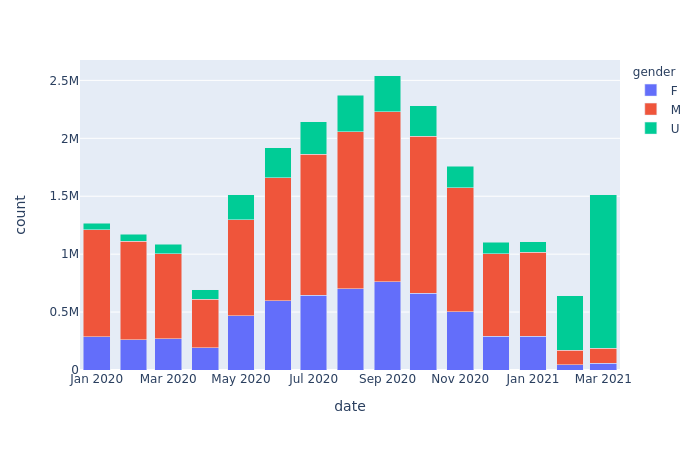

In [13]:
px.bar(
    gc,
    x='date',
    y='count',
    color='gender',
    barmode='stack',
).show(renderer='png')

## "User type" plot <a id="usertype"></a>

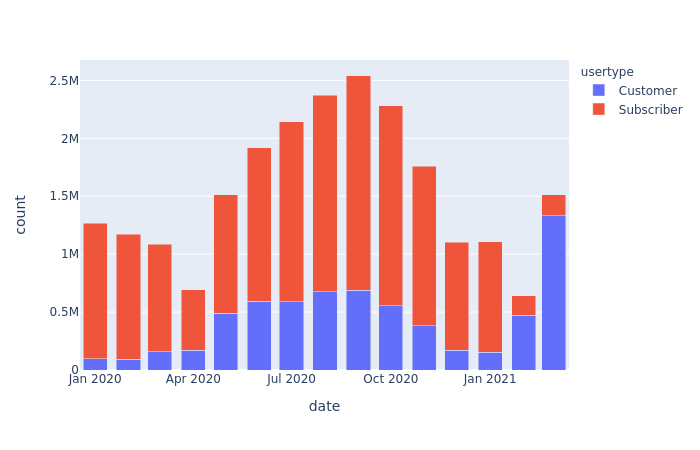

In [14]:
px.bar(
    uc,
    x='date',
    y='count',
    color='usertype',
    barmode='stack',
).show(renderer='png')